In [2]:
# This script generates the Fig. 2: HAR pruning: accuracy vs total memory footprint of the paper.
# Prequisite: Before you run this script in google colab, please make sure that both model_accuracy.data and model_size.data are uploaded from the HAR_Pruning_Quantization/HAR_pruning_output folder
# Import the necessary package
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #if this fails install pandas using import pandas as pd

# Load the model size vs model accuracy
model_accuracy = np.load('model_accuracy.data', allow_pickle=True)
model_size = np.load('model_size.data', allow_pickle=True)


#Create a 2D array list model_size_acc_2d to store the [model size, model accuracy]
L=len(model_accuracy) # We will create a LbyL list of [model size, model accuracy], Here L=219 as per data
model_size_acc_2d = [[0 for i in range(2)] for j in range(L)]
for i in range(L):
    model_size_acc_2d[i][0]=(model_size[L-1-i])/1024 # Convert the bytes data of size into KB
    model_size_acc_2d[i][1]=model_accuracy[L-1-i]
      
# Convert the 2d list to numpy array
model_size_acc_2d=np.asarray(model_size_acc_2d)

# Define a function to identify pareto points from a 2d numpy array [key, value]
def identify_pareto(list_2d):
    # Count number of items
    population_size = list_2d.shape[0]
    # Create a NumPy index for list_2d on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(i):
            # Check if our 'i' pint is dominated by out 'j' point
            if  any(list_2d[j] > list_2d[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

#Identify the pareto points
pareto = identify_pareto(model_size_acc_2d)

#Identify the pareto front using pareto points
pareto_front = model_size_acc_2d[pareto]

# Extract the pareto front values
pareto_front_df = pd.DataFrame(pareto_front)
pareto_front_df.sort_values(0, inplace=True)
pareto_front = pareto_front_df.values








    
    

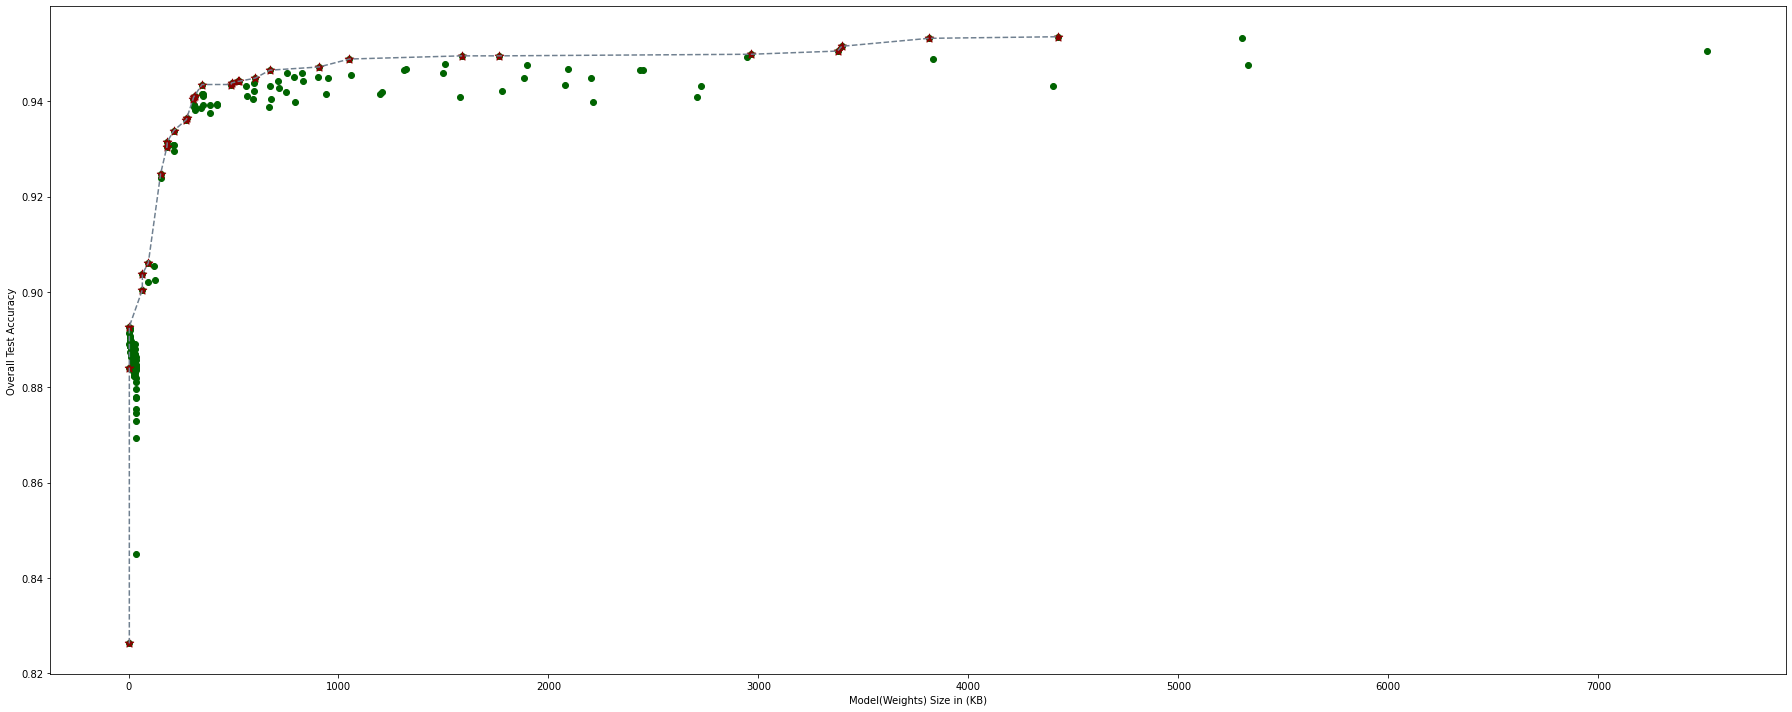

In [3]:
# First we will plot the variation of variation of the overall testing accuracy vs the model (weight) size of the pruned models
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['text.usetex'] = True
x_all = model_size_acc_2d[:, 0]
y_all = model_size_acc_2d[:, 1]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]
params = {'figure.figsize': [25, 10], 'legend.fontsize': 12}
plt.rcParams.update(params)
plt.scatter(x_all, y_all, color='darkgreen')
plt.scatter(x_pareto,y_pareto, marker='*', s=80, color='darkred')
plt.plot(x_pareto, y_pareto, color='slategray',linestyle='dashed')
plt.ylabel('Overall Test Accuracy')
plt.xlabel('Model(Weights) Size in (KB)')
# plt.title("Human activity recognition pruning pareto optimal curve for: Overall test accuracy vs Model(weights) memory", size=20)
plt.tight_layout()
plt.savefig("HAR_pareto_optimal_Overall_test_Accuracy_vs_model_memory.pdf", bbox_inches='tight', dpi=600)
plt.savefig("HAR_pareto_optimal_Overall_test_Accuracy_vs_model_memory.png", bbox_inches='tight', dpi=600)
plt.show()

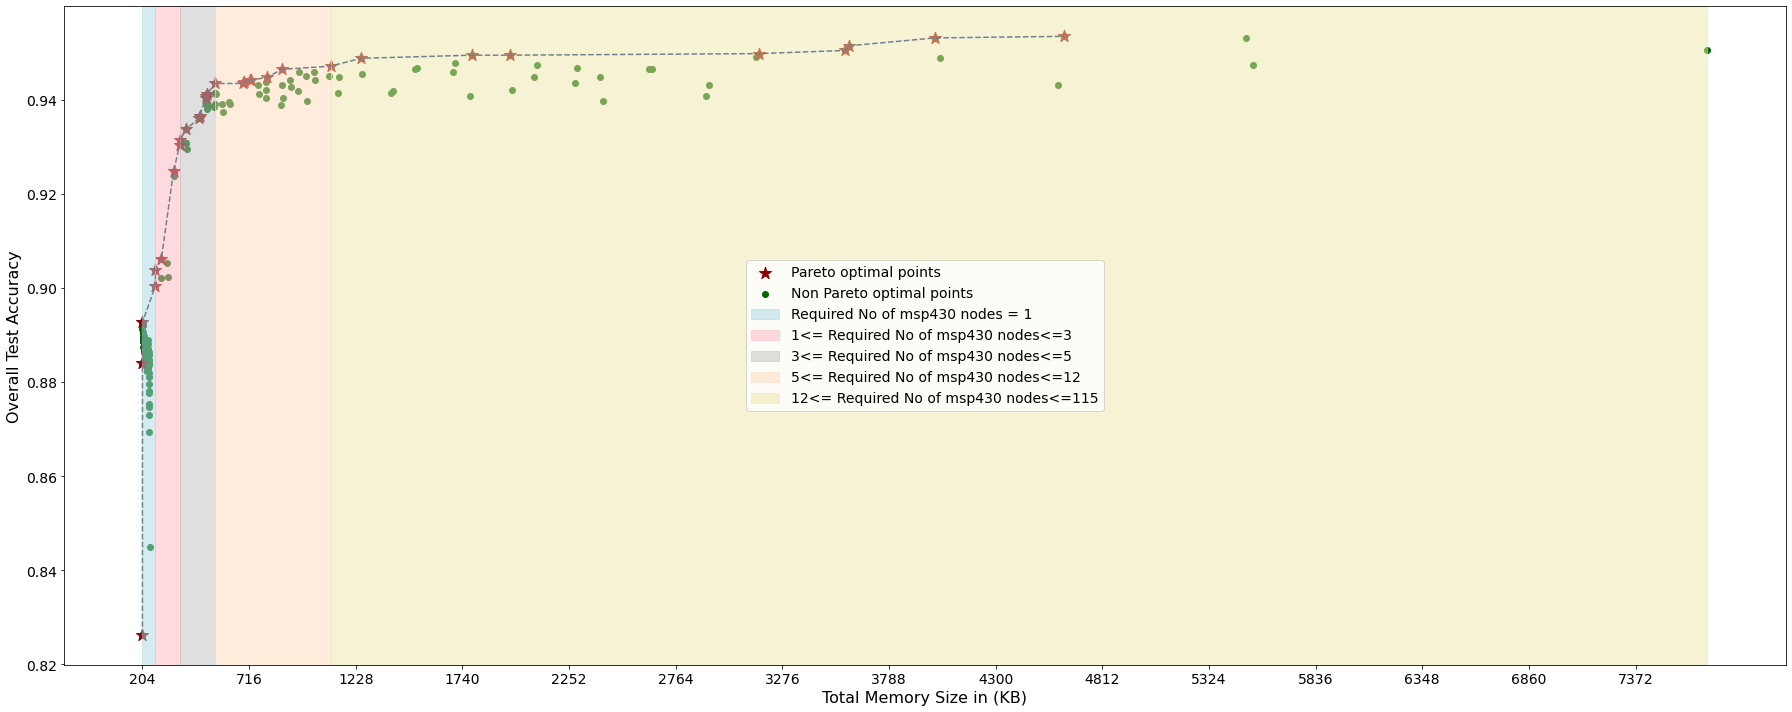

In [4]:
# Now we will plot overall test accuracy acc vs total inference memory footprint
# Total inference memory footprint= (text: Tensorflow-lite compiled operator code memory etc, RAM: Tensorflow-lite runtime RAM , Arena size: Memory needed to store the intermediate tensors and model: size of the weights) 
# For e.g. for HAR we have, 55k arena + 4kB RAM + 140 KB TEXT-CODE= 200 KB in addition to the variable model memory

import matplotlib


x_all = model_size_acc_2d[:, 0]+200
y_all = model_size_acc_2d[:, 1]
x_pareto = pareto_front[:, 0]+ 200
y_pareto = pareto_front[:, 1]
params = {'figure.figsize': [25, 10], 'legend.fontsize': 14}
plt.rcParams.update(params)
r=plt.scatter(x_all, y_all, color='darkgreen')

a=plt.axvspan(x_all[0],x_all[127],alpha=0.5, color='lightblue') #n=1
b=plt.axvspan(x_all[127],x_all[134],alpha=0.5, color='lightpink') # n<=3
c=plt.axvspan(x_all[134],x_all[151],alpha=0.5, color='silver') # n<=5
d=plt.axvspan(x_all[151],x_all[183],alpha=0.5, color='peachpuff') # n<=12
e=plt.axvspan(x_all[183],x_all[218],alpha=0.5, color='palegoldenrod') # n<=115 and n>=12



q=plt.scatter(x_pareto,y_pareto, marker='*', s=160, color='darkred')


plt.plot(x_pareto, y_pareto, color='slategray',linestyle='dashed')


plt.legend((q,r,a,b,c,d,e),('Pareto optimal points','Non Pareto optimal points','Required No of msp430 nodes = 1','1<= Required No of msp430 nodes<=3','3<= Required No of msp430 nodes<=5','5<= Required No of msp430 nodes<=12','12<= Required No of msp430 nodes<=115'),loc="center",prop={'size': 14})




plt.xticks(np.arange(min(x_all), max(x_all)+100, 512),size=14)
plt.yticks(size=14)
plt.ylabel('Overall Test Accuracy',size=16)
plt.xlabel('Total Memory Size in (KB)',size=16)
# plt.title("Human activity recognition pruning pareto optimal curve for: Overall test accuracy vs Model(weights) memory", size=20)
plt.tight_layout()
plt.savefig("HAR_pareto_optimal_Overall_test_Accuracy_vs_Total_memory.pdf", bbox_inches='tight', dpi=600)
plt.savefig("HAR_pareto_optimal_Overall_test_Accuracy_vs_Total_memory.png", bbox_inches='tight', dpi=600)

plt.ticklabel_format(axis='x',style='plain',useOffset=False)
plt.show()